# California Landslide Data Preprocessing

## Overview
This notebook processes landslide data from california for integration with the Cascadia regional dataset. 


### Key Processing Steps:

1. **Load Dataset**

3. **Standardization**: Add filtering column names and data types with unified schema

4. **Export Processing**: Save cleaned data as standardized GeoJSON


# Initial Inspection

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gdf = gpd.read_file("../Data/cgs_DC1_Older_15.geojson")
len(gdf)

2233

In [3]:
# Show all columns when printing DataFrames
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
gdf.head()

,sec_geol_unit_map_symb,SymSize,SHAPE.STArea(),SHAPE.STLength(),OBJECTID,creation_date,revision_date,geom_rev_date,geom_rev_staff,ls_id,ls_master,activity,init_type,subs_type,mvmt_mode,confidence,thickness,dir_mvmt,base_map,map_year,ls_data_source_type,ls_data_source_desc,prim_geol_unit_map_symb,prim_geol_unit_name,sec_geol_unit_name,geol_data_source,strike_az,dip,attitude_type,att_data_source,staff,peer_rev_staff,remarks,data_class,citable_product,mvmt_date_yr,mvmt_date_mon,mvmt_date_day,triggering_event,superseded,citable_product_url,gis_source,created_user,created_date,last_edited_user,last_edited_date,FeatID,display_class,source_layer_id,geometry
0,None,63.999711,5.156009e+05,2685.433679,2,1.349827e+12,NaN,NaN,None,garbv3001,None,dm,rs,None,st,p,d,20.0,None,2012.0,IMG,Air Photo WAC-00-CA_4-2-2000_5-248,TKy,TKy Yager Formation,None,California Division of Mines and Geology Open ...,330.0,74.0,bed,California Division of Mines and Geology Open ...,WDH,None,None,None,,None,None,None,None,N,,G:\CGS\GM_Work\Landslide Inventories\StateLand...,None,NaN,None,NaN,2,1,15,"POLYGON ((-13779203.012 4869656.953, -13779095..."
1,None,53.137356,3.952546e+05,2479.452041,3,1.349914e+12,NaN,NaN,None,garbv3002,None,dm,rs,None,st,d,d,230.0,None,2012.0,IMG,Air Photo WAC-00-CA_4-2-2000_5-168,TKy,TKy Yager Formation,None,California Division of Mines and Geology Open ...,320.0,72.0,bed,California Division of Mines and Geology Open ...,WDH,None,None,None,,None,None,None,None,N,,G:\CGS\GM_Work\Landslide Inventories\StateLand...,None,NaN,None,NaN,3,1,15,"POLYGON ((-13778869.724 4872823.108, -13778893..."
2,None,38.244718,3.007549e+05,2621.319279,8,1.349914e+12,NaN,NaN,None,garbv3008,None,dm,ef,None,cx,d,m,280.0,None,2012.0,IMG,Air Photo WAC-00-CA_4-2-2000_5-250,TKy,TKy Yager Formation,None,California Division of Mines and Geology Open ...,NaN,NaN,None,California Division of Mines and Geology Open ...,WDH,None,None,None,,None,None,None,None,N,,G:\CGS\GM_Work\Landslide Inventories\StateLand...,None,NaN,None,NaN,8,1,15,"POLYGON ((-13776082.124 4872308.313, -13776164..."
3,None,75.675953,1.090724e+06,4804.362975,12,1.341965e+12,NaN,NaN,None,leg3002,None,dm,rs,None,st,d,d,250.0,None,2012.0,IMG,Air Photo WAC-00-CA_4-3-2000_9-154,TKfs,TKfs-Franciscan Coastal Belt Sedimentary Rocks,None,California Division of Mines and Geology Open ...,NaN,NaN,None,None,WDH,None,None,None,,None,None,None,None,N,,G:\CGS\GM_Work\Landslide Inventories\StateLand...,None,NaN,None,NaN,12,1,15,"POLYGON ((-13764273.104 4839689.294, -13764324..."
4,None,95.756685,3.476337e+06,12101.286389,15,1.351728e+12,NaN,NaN,None,miran3000,None,dm,rs,None,sr,d,d,160.0,None,2012.0,IMG,Air Photo WAC-00-CA_4-2-2000_5-174,fm-Franciscan Centr*,fm,None,California Division of Mines and Geology Open ...,NaN,NaN,None,California Division of Mines and Geology Open ...,WDH,None,None,None,,None,None,None,None,N,,G:\CGS\GM_Work\Landslide Inventories\StateLand...,None,NaN,None,NaN,15,1,15,"MULTIPOLYGON (((-13780622.279 4890488.682, -13..."


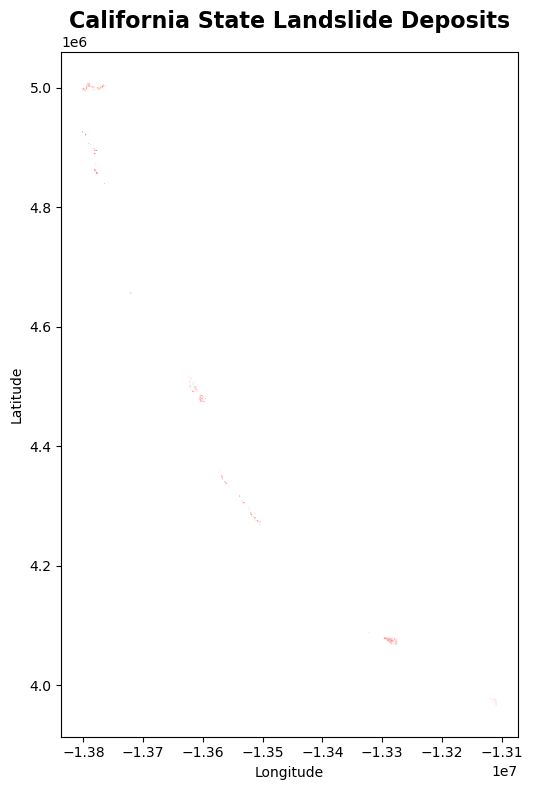

In [4]:
# Simple plot of landslide deposits
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, alpha=0.7, color='red', markersize=0.5)
ax.set_title("California State Landslide Deposits", fontsize=16, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

# Analysis

In [5]:
# Seperating deposits by column types
numerical_cols = gdf.select_dtypes(include=['number']).columns.tolist()

non_numerical_cols = gdf.select_dtypes(exclude=['number']).columns.tolist()

In [6]:
print("Numerical Columns:")
for col in numerical_cols:
    print(f"  - {col}")

print("\nNon-Numerical Columns:")
for col in non_numerical_cols:
    print(f"  - {col}")

Numerical Columns:
  - SymSize
  - SHAPE.STArea()
  - SHAPE.STLength()
  - OBJECTID
  - creation_date
  - revision_date
  - geom_rev_date
  - dir_mvmt
  - map_year
  - strike_az
  - dip
  - created_date
  - last_edited_date
  - FeatID
  - display_class
  - source_layer_id

Non-Numerical Columns:
  - sec_geol_unit_map_symb
  - geom_rev_staff
  - ls_id
  - ls_master
  - activity
  - init_type
  - subs_type
  - mvmt_mode
  - confidence
  - thickness
  - base_map
  - ls_data_source_type
  - ls_data_source_desc
  - prim_geol_unit_map_symb
  - prim_geol_unit_name
  - sec_geol_unit_name
  - geol_data_source
  - attitude_type
  - att_data_source
  - staff
  - peer_rev_staff
  - remarks
  - data_class
  - citable_product
  - mvmt_date_yr
  - mvmt_date_mon
  - mvmt_date_day
  - triggering_event
  - superseded
  - citable_product_url
  - gis_source
  - created_user
  - last_edited_user
  - geometry


# New Columns

## Confidence

We will convert the values into 3 main classes Moderate, High and Low to be more consistent with Washington and Oregon.

### Raw Confidence Values

In [7]:
print("Value Counts for Confidence:")
print(gdf['confidence'].value_counts())

Value Counts for Confidence:
confidence
p    1164
d     633
q     436
Name: count, dtype: int64


### Replacing empty strings with NaN

In [8]:
# Normalize to H/M/L categories
# Assuming the original codes are single letters: p, d, q
mapping = {
    "p": "High",
    "d": "Medium",
    "q": "Low"
}

# Apply the mapping (case-insensitive)
gdf["filter_CONFIDENCE"] = gdf["confidence"].str.lower().map(mapping).fillna("Unknown")

# Quick check
gdf[["filter_CONFIDENCE", "confidence"]].value_counts()


filter_CONFIDENCE  confidence
High               p             1164
Medium             d              633
Low                q              436
Name: count, dtype: int64

## Type

### Original Type

In [9]:
type_counts = gdf['init_type'].value_counts()
print("\nValue Counts for Type:")
print(type_counts)


Value Counts for Type:
init_type
rs    1834
ds     195
ef     154
dn      31
ss       9
df       9
rp       1
Name: count, dtype: int64


### Extracting Material from Type

In [10]:
import pandas as pd

# --- 1) Allowed categories (must match your filter lists exactly) ---
KNOWN_MATERIALS = ["Debris", "Earth", "Rock", "Complex", "Water", "Submarine"]
KNOWN_MOVEMENTS = ["Flow", "Complex", "Slide", "Slide-Rotational", "Slide-Translational",
                   "Avalance", "Flood", "Deformation", "Topple", "Spread", "Submarine"]

# --- 2) Look-up tables (seed set; extend as needed for your dataset) ---
# Map mvmt_mode codes -> movement categories (one or more)
MVMT_MODE_MAP = {
    "st": {"Slide", "Slide-Translational"},
    "sr": {"Slide", "Slide-Rotational"},
    "sc": {"Slide", "Complex"},          # compound slide
    "fl": {"Flow"},
    "av": {"Avalance"},                  # keep your category spelling
    "fd": {"Flood"},
    "dp": {"Deformation"},
    "tp": {"Topple"},
    "sp": {"Spread"},
    "sb": {"Submarine"},
}

# Map init/subs codes -> (materials, movement-hints)
# (Use both init_type and subs_type; union them.)
INIT_SUBS_MAP = {
    "df": ({"Debris"}, {"Flow"}),            # debris flow
    "ef": ({"Earth"}, {"Flow"}),             # earth flow
    "rf": ({"Rock"}, {"Topple"}),            # rock fall -> closest: Topple
    "dl": ({"Debris"}, {"Slide"}),           # debris slide
    "el": ({"Earth"}, {"Slide"}),            # earth slide
    "rl": ({"Rock"}, {"Slide"}),             # rock slide
    "dg": ({"Complex"}, {"Deformation"}),    # disrupted ground
    "dn": ({"Debris"}, {"Flow"}),            # debris fan (flow deposit)
    "la": ({"Water", "Debris"}, {"Flow"}),   # lahar (if present)
    "cm": ({"Complex"}, {"Complex"}),        # explicit complex (if present)
    "sb": ({"Submarine"}, {"Submarine"}),    # submarine (if present)
    # add more codes here as you encounter them
}

def _codeset(v):
    if pd.isna(v): 
        return set()
    s = str(v).strip().lower()
    # handle comma/semicolon separated combos if they occur
    parts = [p.strip() for p in s.replace(";", ",").split(",") if p.strip()]
    return set(parts) if parts else ({s} if s else set())

def infer_material_movement(row):
    mats, movs = set(), set()

    # mvmt_mode is the strongest movement signal
    for code in _codeset(row.get("mvmt_mode")):
        movs |= MVMT_MODE_MAP.get(code, set())

    # init_type and subs_type inform both material and movement
    for code in _codeset(row.get("init_type")) | _codeset(row.get("subs_type")):
        m2, v2 = INIT_SUBS_MAP.get(code, (set(), set()))
        mats |= m2
        movs |= v2

    # Keep only known categories to avoid typos
    mats = [m for m in KNOWN_MATERIALS if m in mats]
    movs = [m for m in KNOWN_MOVEMENTS if m in movs]

    # Fallbacks: if nothing inferred, pick sensible defaults
    if not mats:
        mats = ["Complex"]
    if not movs:
        # If slide subtype present without generic 'Slide', add it
        # (e.g., Slide-Rotational → also include Slide for your filters)
        movs = ["Slide"]

    # Return as semicolon-separated lists to allow combinations
    return pd.Series({
        "material": "; ".join(mats),
        "movement": "; ".join(movs),
    })

# --- 5) Apply inference ---
gdf[["filter_MATERIAL", "filter_MOVEMENT"]] = gdf.apply(infer_material_movement, axis=1)

# --- 6) Quick QA checks ---
print("Material distribution:")
print(gdf["filter_MATERIAL"].value_counts().head(15), "\n")

print("Movement distribution:")
print(gdf["filter_MOVEMENT"].value_counts().head(15))


Material distribution:
filter_MATERIAL
Complex    2013
Earth       164
Debris       56
Name: count, dtype: int64 

Movement distribution:
filter_MOVEMENT
Slide                            1077
Complex; Slide                    494
Slide; Slide-Rotational           225
Slide; Slide-Translational        217
Flow                              214
Flow; Slide; Slide-Rotational       6
Name: count, dtype: int64


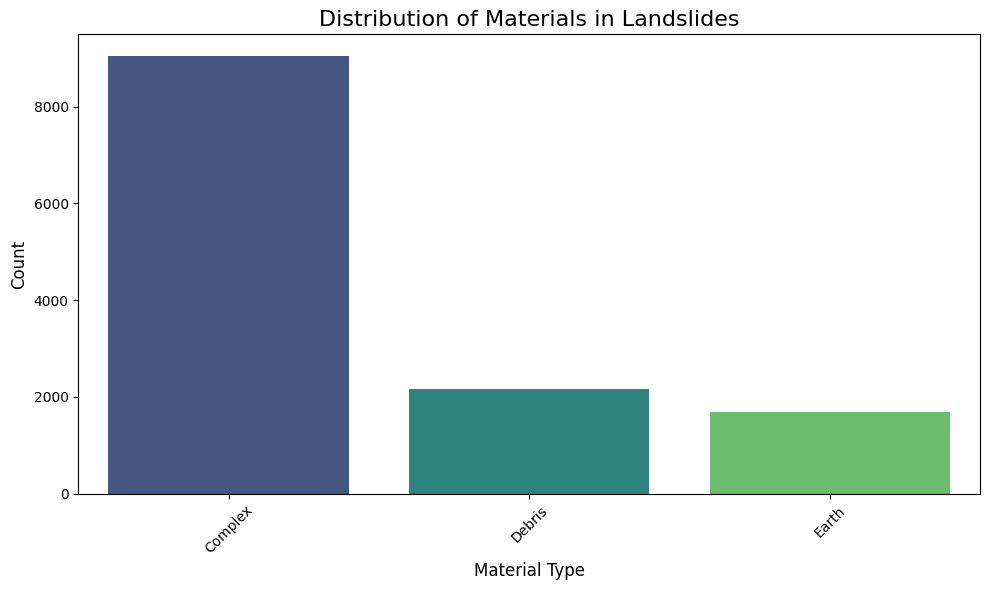

In [37]:
# Plot distribution excluding NaN values
plt.figure(figsize=(10, 6))
non_null_counts = gdf['material'].value_counts()
sns.barplot(x=non_null_counts.index, y=non_null_counts.values, 
            palette='viridis', hue=non_null_counts.index, legend=False)
plt.title('Distribution of Materials in Landslides', fontsize=16)
plt.xlabel('Material Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

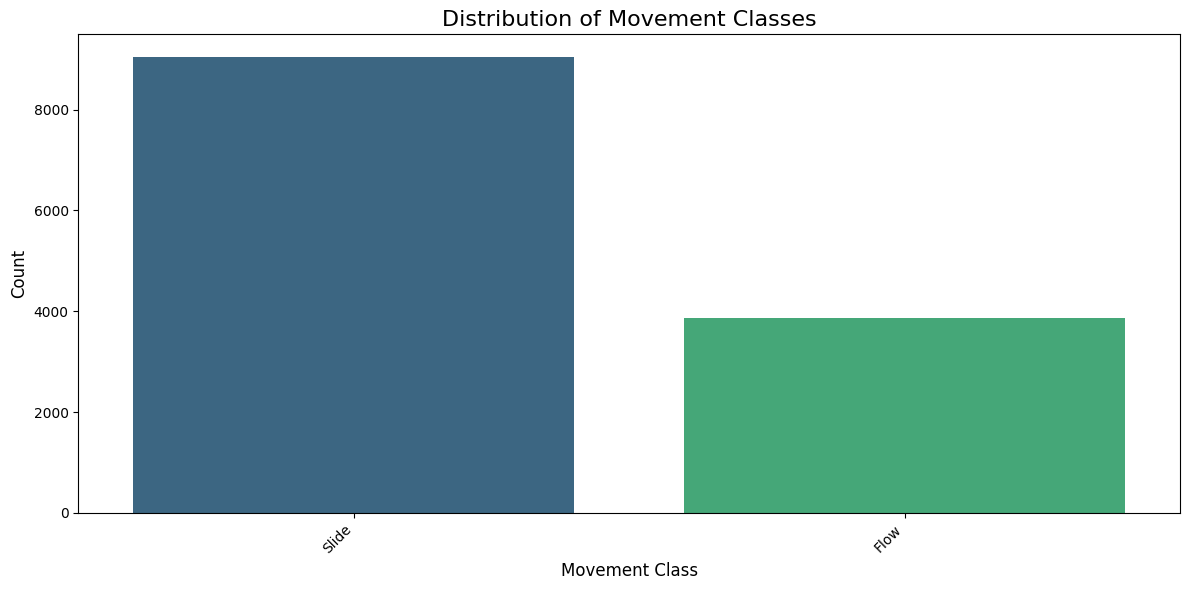

In [38]:
plt.figure(figsize=(12, 6))
non_null_counts = gdf['movement'].value_counts()
sns.barplot(x=non_null_counts.index, y=non_null_counts.values, 
            palette='viridis', hue=non_null_counts.index, legend=False)
plt.title('Distribution of Movement Classes', fontsize=16)
plt.xlabel('Movement Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [39]:
gdf['ORIGIN'] = 'CALIFORNIA'
gdf['Dataset Link'] = 'https://gis.conservation.ca.gov/server/rest/services/CGS/LandslideInventory_DC2/MapServer/13'
gdf['Reference'] = gdf['att_data_source']

# Save into GeoJSON

In [40]:
gdf.to_file("../ProcessedDataSets/CAL_DC2_landslides.geojson", driver='GeoJSON')

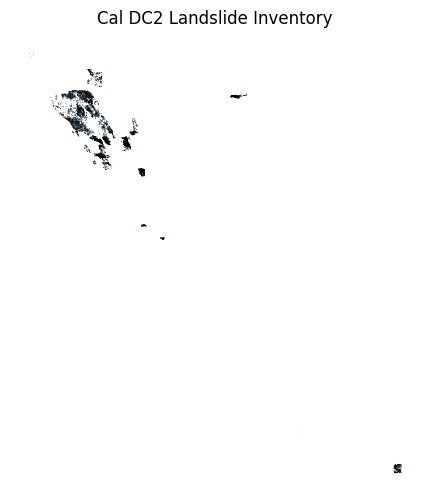

In [41]:
gdf.plot(figsize=(8, 6), edgecolor="k", linewidth=0.2)
plt.title("Cal DC2 Landslide Inventory")
plt.axis("off")
plt.show()